## **Bài toán 1: Dự đoán hiệu suất xe hơi**

 **1. Tải bộ dữ liệu**

In [ ]:
!gdown --id 1qiUDDoYyRLBiKOoYWdFl_5WByHE8Cugu

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1qiUDDoYyRLBiKOoYWdFl_5WByHE8Cugu
To: /content/Auto_MPG_data.csv
100% 15.4k/15.4k [00:00<00:00, 23.0MB/s]


**2. Import các thư viện cần thiết**





In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

**3. Cài đặt giá trị ngẫu nhiên cố định**: Để kết quả trả về là cố định với mỗi lần chúng
ta thực hiện chạy lại từ đầu file notebook, tham số ngẫu nhiên (seed) cần phải được
cài đặt với tất cả các thư viện và hàm có liên quan đến phép ngẫu nhiên. Trong bài
này, các thư viện NumPy, PyTorch, scikit-learn sẽ có một vài hàm có sử dụng tính
ngẫu nhiên, vì vậy ta sẽ cài đặt chung một giá trị ngẫu nhiên như sau:


In [ ]:
random_state = 59
np.random.seed(random_state)
torch.manual_seed(random_state)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_state)

**4. Cài đặt thiết bị tính toán**: Đối với PyTorch, để tận dụng sức mạnh của GPU nếu
có sẵn (trong colab các bạn cần điều chỉnh runtime sang GPU để có thể kích hoạt
được GPU), ta cần chỉ định thiết bị mà mô hình sẽ được chạy. Đoạn code dưới đây sẽ
tự động chọn GPU (nếu khả dụng), hoặc quay về CPU khi GPU không được hỗ trợ:


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

**5. Đọc bộ dữ liệu**

In [ ]:
dataset_path = 'Auto_MPG_data.csv'
dataset = pd.read_csv(dataset_path)
dataset

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
0,18.0,8,307.0,130.0,3504.0,12.0,70,0,0,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,0,0,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,0,0,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,0,0,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,0,0,1
...,...,...,...,...,...,...,...,...,...,...
387,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
388,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
389,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
390,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1


In [ ]:
dataset.describe()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,23.445918,5.471939,194.411990,104.469388,2977.584184,15.541327,75.979592,0.173469,0.201531,0.625000
std,7.805007,1.705783,104.644004,38.491160,849.402560,2.758864,3.683737,0.379136,0.401656,0.484742
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,0.000000,0.000000,0.000000
25%,17.000000,4.000000,105.000000,75.000000,2225.250000,13.775000,73.000000,0.000000,0.000000,0.000000
50%,22.750000,4.000000,151.000000,93.500000,2803.500000,15.500000,76.000000,0.000000,0.000000,1.000000
75%,29.000000,8.000000,275.750000,126.000000,3614.750000,17.025000,79.000000,0.000000,0.000000,1.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,1.000000,1.000000,1.000000


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392 entries, 0 to 391
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MPG           392 non-null    float64
 1   Cylinders     392 non-null    int64  
 2   Displacement  392 non-null    float64
 3   Horsepower    392 non-null    float64
 4   Weight        392 non-null    float64
 5   Acceleration  392 non-null    float64
 6   Model Year    392 non-null    int64  
 7   Europe        392 non-null    int64  
 8   Japan         392 non-null    int64  
 9   USA           392 non-null    int64  
dtypes: float64(5), int64(5)
memory usage: 30.8 KB


**6. Tiền xử lý bộ dữ liệu**: Với DataFrame vừa đọc lên, ta sẽ thực hiện một số bước
tiền xử lý dữ liệu để có thể sử dụng chúng trong việc huấn luyện mô hình.


a) Tách đặc trưng X và nhãn y:

In [ ]:
X = dataset.drop(columns='MPG').values
y = dataset['MPG'].values

b) Chia bộ dữ liệu train/val/test

In [ ]:
val_size = 0.2
test_size = 0.125
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=val_size,
    random_state=random_state,
    shuffle=is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size=test_size,
    random_state=random_state,
    shuffle=is_shuffle
)

c) Chuẩn hóa đặc trưng đầu vào

In [ ]:
normalizer = StandardScaler()
X_train = normalizer.fit_transform(X_train)
X_val = normalizer.transform(X_val)
X_test = normalizer.transform(X_test)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

**7. Xây dựng DataLoader**: Để có thể duyệt qua bộ dữ liệu một cách hiệu quả cho
việc huấn luyện cũng như đánh giá mô hình trong PyTorch, chúng ta cần xây dựng
PyTorch DataLoader. Để xây dựng DataLoader, chúng ta cần phải xây dựng PyTorch
Dataset nhằm lưu dữ liệu đầu vào đầu ra trong bài toán. Theo đó, ta sẽ xây dựng
một PyTorch Dataset đơn giản như sau:


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
      self.X = X
      self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

Sau khi khai báo class PyTorch Dataset, ta chỉ việc gói triển khai của các dataset này
vào DataLoader là hoàn tất. Lưu ý rằng, ở đây ta sẽ khai báo luôn tham số batch
size, vì DataLoader sẽ hỗ trợ chúng ta lấy batch một cách tối ưu hơn:


In [ ]:
batch_size = 32
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,shuffle = True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle = False)

**8. Xây dựng mạng MLP**: Ta triển khai một mạng MLP gồm 2 lớp ẩn, theoo sau mỗi
lớp ẩn là hàm kích hoạt ReLU. Ta cài đặt cấu trúc mạng này trong PyTorch như sau:


In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super().__init__()
        self.linear1 = nn.Linear(input_dims, hidden_dims)
        self.linear2 = nn.Linear(hidden_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)

    def forward(self, x):
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        out = self.output(x)
        return out.squeeze(1)

Sau khi đã có cài đặt class cho kiến trúc MLP, ta sẽ khai báo biến mô hình bằng cách
khai báo một đối tượng của class trên đi kèm với các tham số phù hợp với bài toán
đang giải:


In [ ]:
input_dims = X_train.shape[1]
ouput_dims = 1
hidden_dims = 64

model = MLP(input_dims = input_dims, output_dims = ouput_dims, hidden_dims = hidden_dims).to(device)

**9. Khai báo hàm loss và opimizer:** Đối với PyTorch, ta có thể dễ dàng cài đặt hàm
loss cũng như thuật toán tối ưu bằng class có sẵn. Trong bài này, ta sử dụng hàm
Mean Squared Error Loss (MSELoss) cũng như thuật toán tối ưu Stochastic Gradient
Descent (SGD):


In [ ]:
lr = 1e-2
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

**10. Xây dựng hàm tính điểm R2**: Trong bài này, ta sẽ sử dụng thêm một độ đo khác
cho bài regression là điểm R2 (Coefficient of determination). Cách triển khai như sau:



In [ ]:
def r_squared(y_true, y_pred):
    y_true = torch.Tensor(y_true).to(device)
    y_pred = torch.Tensor(y_pred).to(device)
    mean_true = torch.mean(y_true)
    ss_tot = torch.sum((y_true - mean_true) ** 2)
    ss_res = torch.sum((y_true - y_pred) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    return r2

**11. Huấn luyện mô hình:** Khi đã đầy đủ tất cả gồm mô hình, dataloader, hàm loss và
optimizer, chúng ta đã có thể tiến hành huấn luyện mô hình trong PyTorch. Cách cài
đặt như sau:

In [ ]:
epochs = 100
train_losses = []
val_losses = []
train_r2 = []
val_r2 = []
for epoch in range(epochs):
    train_loss = 0.0
    train_target = []
    val_target = []
    train_predict = []
    val_predict = []
    model.train()
    for X_samples, y_samples in train_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        optimizer.zero_grad()
        outputs = model(X_samples)
        train_predict += outputs.tolist()
        train_target += y_samples.tolist()
        loss = criterion(outputs, y_samples)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    train_r2.append(r_squared(train_target, train_predict))
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_samples, y_samples in val_loader:
            X_samples = X_samples.to(device)
            y_samples = y_samples.to(device)
            outputs = model(X_samples)
            val_predict += outputs.tolist()
            val_target += y_samples.tolist()
            loss = criterion(outputs, y_samples)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_r2.append(r_squared(val_target, val_predict))
    print(f'\nEPOCH {epoch + 1}:\tTraining loss: {train_loss:.3f}\tValidation loss: {val_loss:.3f}')


EPOCH 1:	Training loss: 505.281	Validation loss: 491.082

EPOCH 2:	Training loss: 340.647	Validation loss: 754.735

EPOCH 3:	Training loss: 425.377	Validation loss: 89.158

EPOCH 4:	Training loss: 225.327	Validation loss: 34.338

EPOCH 5:	Training loss: 51.620	Validation loss: 17.634

EPOCH 6:	Training loss: 22.450	Validation loss: 13.569

EPOCH 7:	Training loss: 24.993	Validation loss: 6.496

EPOCH 8:	Training loss: 25.447	Validation loss: 9.104

EPOCH 9:	Training loss: 8.315	Validation loss: 7.266

EPOCH 10:	Training loss: 17.550	Validation loss: 22.962

EPOCH 11:	Training loss: 24.630	Validation loss: 15.677

EPOCH 12:	Training loss: 35.213	Validation loss: 6.616

EPOCH 13:	Training loss: 8.442	Validation loss: 8.611

EPOCH 14:	Training loss: 16.839	Validation loss: 23.167

EPOCH 15:	Training loss: 20.985	Validation loss: 7.409

EPOCH 16:	Training loss: 13.039	Validation loss: 6.115

EPOCH 17:	Training loss: 9.110	Validation loss: 5.799

EPOCH 18:	Training loss: 11.708	Validation l

**12. Đánh giá mô hình:**

In [ ]:
model.eval()
with torch.no_grad():
    y_hat = model(X_val)
    val_set_r2 = r_squared(y_hat, y_val)
    print('Evaluation on validation set:')
    print(f'R2: {val_set_r2}')

Evaluation on validation set:
R2: 0.9196450710296631


## **Bài toán 2: Phân loại với dữ liệu phi tuyến**

Đây là một bài toán đơn giản về
classification trên dữ liệu phi tuyến (nonlinear data), bài tập này nhằm mục đích mô tả về
khả năng của một mạng Multilayer Perceptron với những dữ liệu phân bố phức tạp hơn.


**1. Tải bộ dữ liệu**

In [ ]:
!gdown --id 1SqSn_8rxkk-Qvu4JLMcN_3ZFGDNa6P_V

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1SqSn_8rxkk-Qvu4JLMcN_3ZFGDNa6P_V
To: /content/NonLinear_data.npy
100% 5.57k/5.57k [00:00<00:00, 14.8MB/s]


**2. Import các thư viện cần thiết**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

**3. Cài đặt giá trị ngẫu nhiên cố định và thiết bị tính toán**

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
random_state = 59
np.random.seed(random_state)
torch.manual_seed(random_state)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_state)

**4. Đọc bộ dữ liệu**: Dữ liệu cho bài toán phân loại được lưu dưới dạng .npy (Python
NumPy Array File). Ta sử dụng np.load để tải dữ liệu từ file này, thu được một dictionary với hai phần: X là ma trận đặc trưng có kích thước (300, 2) (300 mẫu, mỗi
mẫu có 2 đặc trưng) và y là vector chứa 300 nhãn tương ứng.



In [ ]:
data_path = '/content/NonLinear_data.npy'
data = np.load(data_path, allow_pickle=True).item()
X, y = data['X'], data['labels']
print(X.shape, y.shape)

(300, 2) (300,)


**5. Chia bộ dữ liệu train/val/test**

In [ ]:
val_size = 0.2
test_size = 0.125
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=val_size,
    random_state=random_state,
    shuffle=is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size=test_size,
    random_state=random_state,
    shuffle=is_shuffle
)

In [ ]:
print(f'Number of training samples: {X_train.shape[0]}')
print(f'Number of val samples: {X_val.shape[0]}')
print(f'Number of test samples: {X_test.shape[0]}')

Number of training samples: 210
Number of val samples: 60
Number of test samples: 30


**6. Chuẩn hóa đặc trưng đầu vào**

In [ ]:
normalizer = StandardScaler()
X_train = normalizer.fit_transform(X_train)
X_val = normalizer.transform(X_val)
X_test = normalizer.transform(X_test)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

<ipython-input-49-71adf350ac80>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.long)
<ipython-input-49-71adf350ac80>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_val = torch.tensor(y_val, dtype=torch.long)
<ipython-input-49-71adf350ac80>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.long)


**7. Xây dựng DataLoader**:

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
      self.X = X
      self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
batch_size = 32
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
test_dataset = CustomDataset(X_test, y_test)
train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,shuffle = True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle = False)

**8. Xây dựng mạng MLP**: Để giải quyết bài toán phân loại phi tuyến với dữ liệu có
2 đặc trưng và 3 lớp, chúng ta xây dựng một mạng MLP gồm 2 lớp ẩn với hàm kích
hoạt ReLU sau mỗi lớp. Cấu trúc này giúp mô hình học các đặc trưng phi tuyến trong
dữ liệu.


In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(input_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        out = self.output(x)
        return out.squeeze(1)

Thiết lập các tham số cho mạng MLP, bao gồm số lượng node cho
đầu vào (input_dims), số node trong lớp ẩn (hidden_dims), và số node cho đầu ra
(output_dims).


In [ ]:
input_dims = X_train.shape[1]
output_dims = torch.unique(y_train).shape[0]
hidden_dims = 128

model = MLP(input_dims = input_dims, output_dims = output_dims, hidden_dims = hidden_dims).to(device)

Để xác định output_dims - tức số lớp cần phân loại, tương ứng với số nhãn khác
nhau có trong y_train, chúng ta sử dụng cách đếm số nhãn duy nhất trong y_train
bằng hàm torch.unique, giúp mô hình tự động thích ứng với các bài toán có số lớp
khác nhau mà không cần phải thay đổi thủ công.


**9. Khai báo hàm loss và optimizer**: Ta sử dụng hàm mất mát Cross Entropy cho bài
toán phân loại đa lớp, cùng với thuật toán tối ưu SGD (Stochastic Gradient Descent).


In [ ]:
lr = 1e-1
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

**10. Xây dựng hàm tính độ chính xác**: Để đánh giá hiệu suất của mô hình, chúng
ta định nghĩa hàm compute_accuracy, tính độ chính xác phân loại (classification
accuracy) bằng cách chia số dự đoán đúng cho tổng số mẫu, công thức chung có dạng:


In [ ]:
def compute_accuracy(y_hat, y_true):
    _, y_hat = torch.max(y_hat, dim=1)
    correct = (y_hat == y_true).sum().item()
    accuracy = correct / len(y_true)
    return accuracy

**11. Huấn luyện mô hình**

In [ ]:
epochs = 100
train_losses = []
train_accs = []
val_losses = []
val_accs = []
for epoch in range(epochs):
    train_loss = 0.0
    train_target = []
    train_predict = []
    model.train()
    for X_samples, y_samples in train_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        optimizer.zero_grad()
        outputs = model(X_samples)
        loss = criterion(outputs, y_samples)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        train_predict.append(outputs.detach().cpu())
        train_target.append(y_samples.cpu())

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    train_predict = torch.cat(train_predict)
    train_target = torch.cat(train_target)
    train_acc = compute_accuracy(train_predict, train_target)
    train_accs.append(train_acc)

    val_loss = 0.0
    val_target = []
    val_predict = []
    model.eval()
    with torch.no_grad():
        for X_samples, y_samples in val_loader:
            X_samples = X_samples.to(device)
            y_samples = y_samples.to(device)
            outputs = model(X_samples)
            val_loss += criterion(outputs, y_samples).item()

            val_predict.append(outputs.cpu())
            val_target.append(y_samples.cpu())

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    val_predict = torch.cat(val_predict)
    val_target = torch.cat(val_target)
    val_acc = compute_accuracy(val_predict, val_target)
    val_accs.append(val_acc)

    print(f'\nEPOCH {epoch + 1}:\tTraining loss: {train_loss:.3f}\tValidation loss: {val_loss:.3f}')


EPOCH 1:	Training loss: 0.908	Validation loss: 0.854

EPOCH 2:	Training loss: 0.759	Validation loss: 0.821

EPOCH 3:	Training loss: 0.707	Validation loss: 0.799

EPOCH 4:	Training loss: 0.678	Validation loss: 0.800

EPOCH 5:	Training loss: 0.657	Validation loss: 0.755

EPOCH 6:	Training loss: 0.638	Validation loss: 0.755

EPOCH 7:	Training loss: 0.635	Validation loss: 0.699

EPOCH 8:	Training loss: 0.595	Validation loss: 0.682

EPOCH 9:	Training loss: 0.579	Validation loss: 0.654

EPOCH 10:	Training loss: 0.560	Validation loss: 0.649

EPOCH 11:	Training loss: 0.560	Validation loss: 0.621

EPOCH 12:	Training loss: 0.561	Validation loss: 0.618

EPOCH 13:	Training loss: 0.537	Validation loss: 0.601

EPOCH 14:	Training loss: 0.529	Validation loss: 0.573

EPOCH 15:	Training loss: 0.513	Validation loss: 0.556

EPOCH 16:	Training loss: 0.499	Validation loss: 0.558

EPOCH 17:	Training loss: 0.496	Validation loss: 0.523

EPOCH 18:	Training loss: 0.480	Validation loss: 0.515

EPOCH 19:	Training

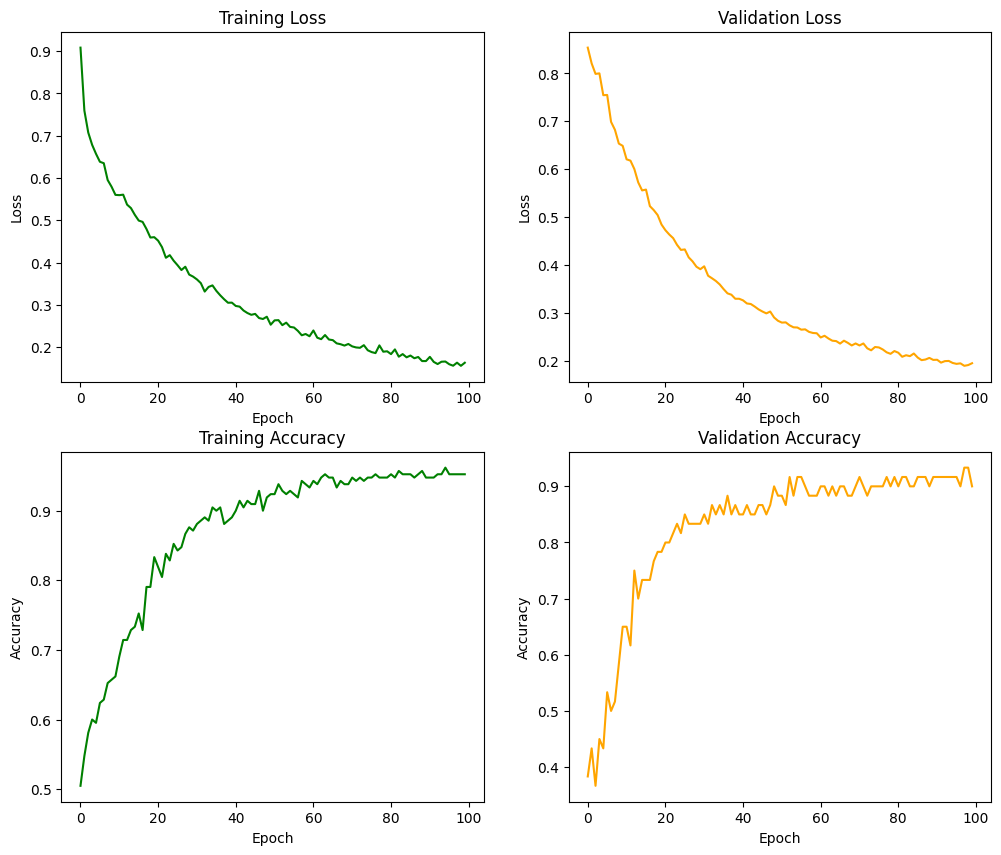

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_losses, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_losses, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_accs, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_accs, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()

In [ ]:
val_target = []
val_predict = []
model.eval()
with torch.no_grad():
    for X_samples, y_samples in val_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        outputs = model(X_samples)

        val_predict.append(outputs.cpu())
        val_target.append(y_samples.cpu())

    val_predict = torch.cat(val_predict)
    val_target = torch.cat(val_target)
    val_acc = compute_accuracy(val_predict, val_target)

    print('Evaluation on val set:')
    print(f'Accuracy: {val_acc}')

Evaluation on val set:
Accuracy: 0.9


In [ ]:
test_target = []
test_predict = []
model.eval()
with torch.no_grad():
    for X_samples, y_samples in test_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        outputs = model(X_samples)

        test_predict.append(outputs.cpu())
        test_target.append(y_samples.cpu())

    test_predict = torch.cat(test_predict)
    test_target = torch.cat(test_target)
    test_acc = compute_accuracy(test_predict, test_target)

    print('Evaluation on test set:')
    print(f'Accuracy: {test_acc}')

Evaluation on test set:
Accuracy: 0.9


# **Bài toán 3: Phân loại cảm xúc trên ảnh**

**1. Tải bộ dữ liệu**

In [ ]:
!gdown --id 1GaTMURqIQTjtalbNVAyVgPIEis21A0r8

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1GaTMURqIQTjtalbNVAyVgPIEis21A0r8
From (redirected): https://drive.google.com/uc?id=1GaTMURqIQTjtalbNVAyVgPIEis21A0r8&confirm=t&uuid=f6e1a734-220a-40f6-a403-32bff8e3588d
To: /content/FER-2013.zip
100% 63.3M/63.3M [00:00<00:00, 144MB/s]


Bài toán 3 sử dụng data dạng ảnh. Khi download data về sẽ là một file nén dạng .zip,
do đó chúng ta cần giải nén ra như bên dưới


In [ ]:
!unzip -q './FER-2013.zip'

**2. Import các thư viện cần thiết**

In [ ]:
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Resize
from torchvision.io import read_image

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

**3. Cài đặt giá trị ngẫu nhiên cố định và thiết bị tính toán**

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
random_state = 59
np.random.seed(random_state)
torch.manual_seed(random_state)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_state)

**4. Đọc số lượng class trong dataset**: Thiết lập đường dẫn đến thư mục train và test.
Chúng ta lấy danh sách tên các thư mục con trong thư mục train, đại diện cho các
lớp cảm xúc khác nhau. Mỗi thư mục con này chứa các ảnh thuộc về một lớp cụ thể.


In [ ]:
train_dir = '/content/train'
test_dir = '/content/test'

classes = os.listdir(train_dir)

label2idx = {cls:idx for idx, cls in enumerate(classes)}
idx2label = {idx:cls  for cls, idx in label2idx.items()}

Sau đó, chúng ta xây dựng hai dict là label2idx và idx2label để ánh xạ giữa tên và
chỉ số lớp, nhằm thuận tiện cho việc xử lý dữ liệu.


In [ ]:
test_img_path = '/content/train/angry/Training_10118481.jpg'
img = cv2.imread(test_img_path)
img_height, img_width = (128, 128)
print(f'Image height: {img_height}')
print(f'Image width: {img_width}')

Image height: 128
Image width: 128


**5. Xây dựng DataLoader**: Xây dựng DataLoader cho bài toán phân loại cảm xúc ảnh
từ tập FER-2013. Trước tiên, lớp tùy chỉnh ImageDataset được tạo ra để quản lý và
xử lý dữ liệu ảnh. Lớp này sẽ cung cấp các phương thức để lấy danh sách đường dẫn
ảnh và nhãn, tính số lượng ảnh, cũng như chuẩn hóa từng ảnh đầu vào (nếu cần)
trước khi đưa vào mô hình.


In [ ]:
class ImageDataset(Dataset):
      def __init__(self, img_dir, norm, label2idx, split='train', train_ratio=0.8):
          self.resize = Resize((img_height, img_width))
          self.norm = norm
          self.split = split
          self.train_ratio = train_ratio
          self.img_dir = img_dir
          self.label2idx = label2idx
          self.img_paths, self.img_labels = self.read_img_files()

          if split in ['train', 'val'] and 'train' in img_dir.lower():
              train_data, val_data = train_test_split(
                  list(zip(self.img_paths, self.img_labels)),
                  train_size=train_ratio,
                  random_state=random_state,
                  stratify = self.img_labels
              )
              if split == 'train':
                  self.img_paths, self.img_labels = zip(*train_data)
              elif split == 'val':
                  self.img_paths, self.img_labels = zip(*val_data)
      def read_img_files(self):
          img_paths = []
          img_labels = []
          for cls in self.label2idx.keys():
              for img in os.listdir(os.path.join(self.img_dir, cls)):
                  img_paths.append(os.path.join(self.img_dir, cls, img))
                  img_labels.append(cls)
          return img_paths, img_labels
      def __len__(self):
          return len(self.img_paths)
      def __getitem__(self, idx):
          img_path = self.img_paths[idx]
          cls = self.img_labels[idx]
          img = self.resize(read_image(img_path))
          img = img.type(torch.float32)
          label = self.label2idx[cls]
          if self.norm:
              img = (img/127.5) - 1
          return img, label

Sau đó, DataLoader được khởi tạo cho các tập train, val, và test với batch size là 256.


In [ ]:
batch_size = 256

train_dataset = ImageDataset(train_dir, True, label2idx, split='train')
val_dataset = ImageDataset(train_dir, True, label2idx, split='val')
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataset = ImageDataset(test_dir, True, label2idx, split='test')
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Để trực quan hóa dữ liệu, chúng ta lấy một batch ảnh từ train_loader và hiển thị 9
hình đầu tiên. Các ảnh này được gắn nhãn cảm xúc tương ứng dựa trên idx2label,
giúp ta có cái nhìn trực quan về dữ liệu mà mô hình sẽ được học.


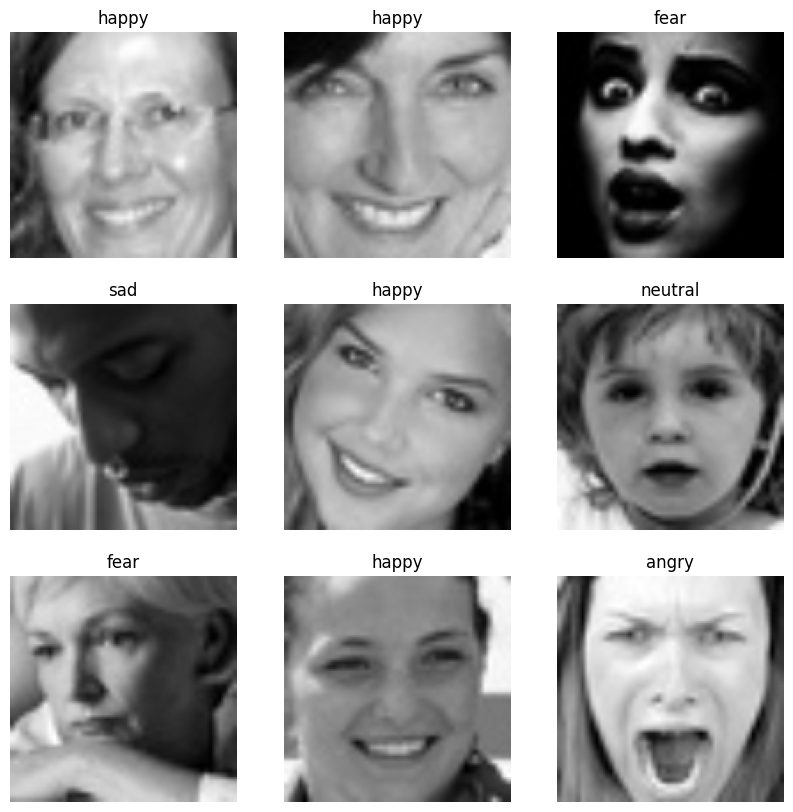

In [ ]:
image_batch, label_batch = next(iter(train_loader))

plt.figure(figsize=(10,10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    minv = image_batch[i].numpy().min()
    maxv = image_batch[i].numpy().max()
    plt.imshow(np.squeeze(image_batch[i].numpy()), vmin = minv, vmax = maxv, cmap='gray')
    label = label_batch[i]
    plt.title(idx2label[label.item()])
    plt.axis('off')

**6. Xây dựng mạng MLP**

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(input_dims, hidden_dims*4)
        self.linear2 = nn.Linear(hidden_dims*4, hidden_dims*2)
        self.linear3 = nn.Linear(hidden_dims*2, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)

    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x)
        x = F.relu(x)
        out = self.output(x)
        return out.squeeze(1)
input_dims = img_height * img_width
output_dims = len(classes)
hidden_dims = 64
lr = 1e-2

model = MLP(input_dims = input_dims, output_dims = output_dims, hidden_dims = hidden_dims).to(device)

**7. Khai báo hàm loss và optimizer**

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

**8. Xây dựng hàm tính độ chính xác**

In [ ]:
def compute_accuracy(y_hat, y_true):
    _, y_hat = torch.max(y_hat, dim=1)
    correct = (y_hat == y_true).sum().item()
    accuracy = correct / len(y_true)
    return accuracy

**9. Huấn luyện mô hình**

In [ ]:
epochs = 40
train_losses = []
train_accs = []
val_losses = []
val_accs = []
for epoch in range(epochs):
    train_loss = 0.0
    train_target = []
    train_predict = []
    model.train()
    for X_samples, y_samples in train_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        optimizer.zero_grad()
        outputs = model(X_samples)
        loss = criterion(outputs, y_samples)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        train_predict.append(outputs.detach().cpu())
        train_target.append(y_samples.cpu())

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    train_predict = torch.cat(train_predict)
    train_target = torch.cat(train_target)
    train_acc = compute_accuracy(train_predict, train_target)
    train_accs.append(train_acc)

    val_loss = 0.0
    val_target = []
    val_predict = []
    model.eval()
    with torch.no_grad():
        for X_samples, y_samples in val_loader:
            X_samples = X_samples.to(device)
            y_samples = y_samples.to(device)
            outputs = model(X_samples)
            val_loss += criterion(outputs, y_samples).item()

            val_predict.append(outputs.cpu())
            val_target.append(y_samples.cpu())

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    val_predict = torch.cat(val_predict)
    val_target = torch.cat(val_target)
    val_acc = compute_accuracy(val_predict, val_target)
    val_accs.append(val_acc)

    print(f'\nEPOCH {epoch + 1}:\tTraining loss: {train_loss:.3f}\tValidation loss: {val_loss:.3f}')


EPOCH 1:	Training loss: 1.907	Validation loss: 1.880

EPOCH 2:	Training loss: 1.850	Validation loss: 1.826

EPOCH 3:	Training loss: 1.807	Validation loss: 1.799

EPOCH 4:	Training loss: 1.787	Validation loss: 1.783

EPOCH 5:	Training loss: 1.773	Validation loss: 1.770

EPOCH 6:	Training loss: 1.759	Validation loss: 1.756

EPOCH 7:	Training loss: 1.743	Validation loss: 1.740

EPOCH 8:	Training loss: 1.724	Validation loss: 1.720

EPOCH 9:	Training loss: 1.702	Validation loss: 1.698

EPOCH 10:	Training loss: 1.680	Validation loss: 1.678

EPOCH 11:	Training loss: 1.661	Validation loss: 1.662

EPOCH 12:	Training loss: 1.645	Validation loss: 1.651

EPOCH 13:	Training loss: 1.633	Validation loss: 1.641

EPOCH 14:	Training loss: 1.623	Validation loss: 1.635

EPOCH 15:	Training loss: 1.613	Validation loss: 1.628

EPOCH 16:	Training loss: 1.605	Validation loss: 1.622

EPOCH 17:	Training loss: 1.597	Validation loss: 1.616

EPOCH 18:	Training loss: 1.589	Validation loss: 1.610

EPOCH 19:	Training

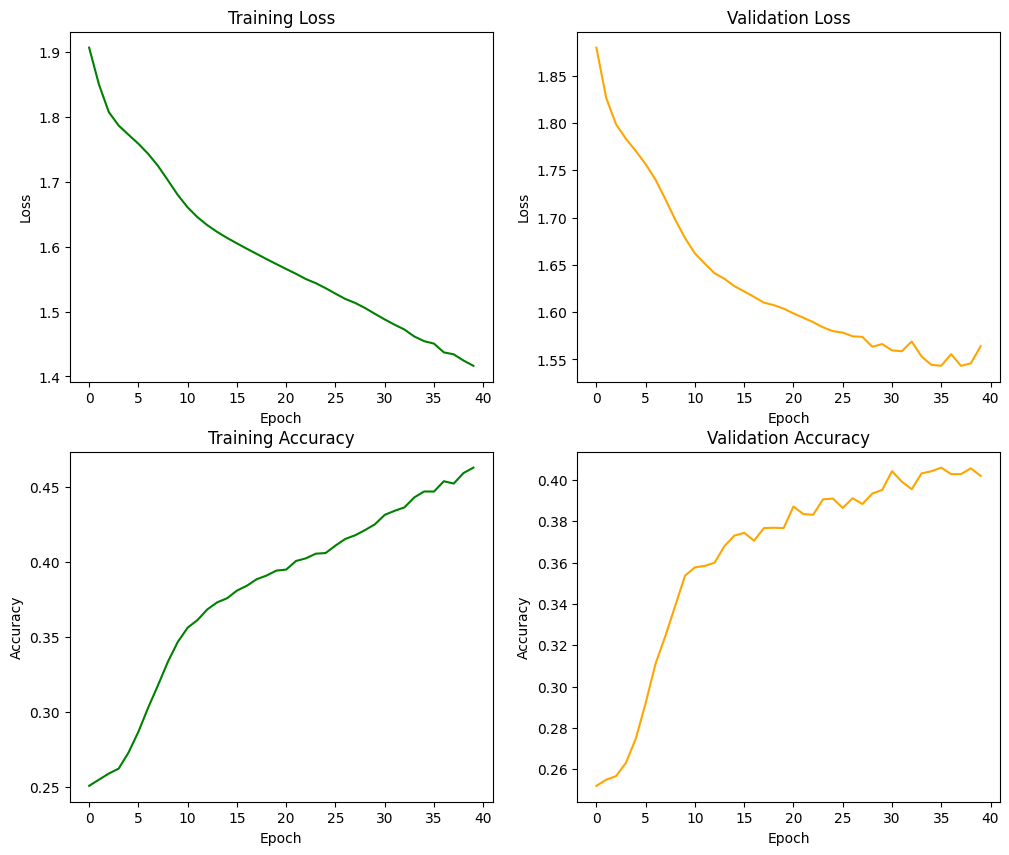

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_losses, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_losses, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_accs, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_accs, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()

In [ ]:
val_target = []
val_predict = []
model.eval()
with torch.no_grad():
    for X_samples, y_samples in val_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        outputs = model(X_samples)

        val_predict.append(outputs.cpu())
        val_target.append(y_samples.cpu())

    val_predict = torch.cat(val_predict)
    val_target = torch.cat(val_target)
    val_acc = compute_accuracy(val_predict, val_target)

    print('Evaluation on val set:')
    print(f'Accuracy: {val_acc}')

Evaluation on val set:
Accuracy: 0.40195053988157436


In [ ]:
test_target = []
test_predict = []
model.eval()
with torch.no_grad():
    for X_samples, y_samples in test_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        outputs = model(X_samples)

        test_predict.append(outputs.cpu())
        test_target.append(y_samples.cpu())

    test_predict = torch.cat(test_predict)
    test_target = torch.cat(test_target)
    test_acc = compute_accuracy(test_predict, test_target)

    print('Evaluation on test set:')
    print(f'Accuracy: {test_acc}')

Evaluation on test set:
Accuracy: 0.40847032599609917
